==============================================================================================
# Practicum 6 

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline: December 22th, 23:00 h**

==============================================================================================

## Imports

In [1]:
from time import time
import os

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import io

# Split dataset into training and test
from sklearn.model_selection import train_test_split 

### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=2500>

**the value at any point (x, y) represents the sum of the pixel values in the rectangular region from the origin (0, 0) to (x, y) in the original image.**

An example :

<img src="notebook_images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**This is because the formula for computing the sum of the pixel values in a rectangular region of the original image using the integral image involves using indices that are one less than the indices of the top-left and bottom-right corners of the rectangular region.**

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one.

In [2]:
import numpy as np

def to_integral_image(original):
    # Create an array of zeros with the same shape as the original image,
    # but with an additional row and column
    integral = np.zeros((original.shape[0], original.shape[1]))
    
    # Loop through the rows and columns of the original image
    for i in range(1, original.shape[0]):
        for j in range(1, original.shape[1]):
            # Compute the value of the integral image at position (i, j)
            integral[i][j] = integral[i-1][j] + integral[i][j-1] - integral[i-1][j-1] + original[i-1][j-1]
    
    #to check manually
    #print(integral)
    return integral


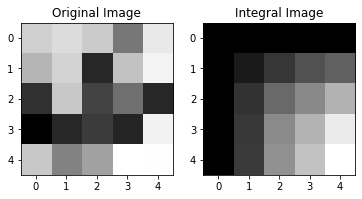

In [3]:
import matplotlib.pyplot as plt

# Generate a random 5x5 grayscale image
original = np.random.randint(0, 256, size=(5, 5))

# Compute the integral image
integral = to_integral_image(original)

# Visualize the original and integral images
plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(integral, cmap='gray')
plt.title('Integral Image')

plt.show()


To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [4]:
#your solution
#Check that the sum of the pixel values in the original image is equal to the value in the bottom-right 
#corner of the integral image (should be True)
print(original.sum() == integral[-1,-1]) 
print(original.sum())
print(integral[-1,-1]) 



#Check that the sum of the pixel values in the first row of the original image is equal to the value in
#the second row and last column of the integral image (should be True)
print(original[0,:].sum() == integral[1,-1])
print(original[0,:].sum())
print(integral[1,-1])

False
3637
1928.0
False
955
730.0


**1.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

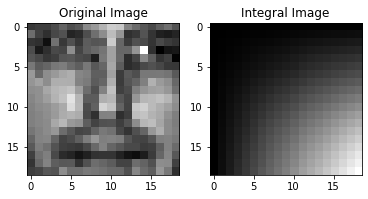

In [5]:
#your solution

# Load the image from the directory
image_face = io.imread('./faces/face00004.png')

# Compute the integral image
integral_image = to_integral_image(image_face)

# Visualize the original image and the integral image
plt.subplot(1, 2, 1)
plt.imshow(image_face, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(integral_image, cmap='gray')
plt.title('Integral Image')
plt.show()


What do the following lines mean? How can you explain this?

- `img_array.sum() == ii_img_array[-1,-1]`
- `img_array[0,:].sum() == ii_img_array[1,-1]`
- `ii_img_array[0,-1].sum() == 0`
 
 
 **The following lines are tests that can be used to verify that the integral image is correct**

In [6]:
#This line checks that the sum of the pixel values in the original image is equal to the value in the bottom-right corner 
#of the integral image. This should be true because the bottom-right corner of the integral image corresponds to the sum of 
#the pixel values in the rectangular region from the origin to the bottom-right corner of the original image.
print(image_face.sum() == integral_image[-1,-1])
print(image_face.sum())
print(integral_image[-1,-1])

#This line checks that the sum of the pixel values in the first row of the original image is equal to the value in the second 
#row and last column of the integral image. This should be true because the second row and last column of the integral image 
#corresponds to the sum of the pixel values in the rectangular region from the origin to the second row and last column of 
#the original image, which includes the first row of the original image.
print(image_face[0,:].sum() == integral_image[1,-1])
print(image_face[0,:].sum())
print(integral_image[1,-1])




#This line checks that the sum of the pixel values in the first column of the integral image is equal to zero. This should be 
#true because the first column of the integral image is padded with zeros.
print(integral_image[0,-1].sum() == 0)

False
41335
37349.0
False
2189
2089.0
True


**1.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage.

4156.0


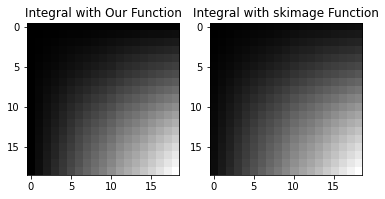

In [7]:
#your solution
from skimage.transform import integral_image

# Load the image from the directory
image_face = io.imread('./faces/face00004.png')

# Compute the integral image using your own function
integral_image1 = to_integral_image(image_face)

# Compute the integral image using the skimage function
integral_image2 = integral_image(image_face)

# Compare the two integral images numerically
print(np.abs(integral_image1 - integral_image2).max())


# Visualize the two integral images
plt.subplot(1, 2, 1)
plt.imshow(integral_image1, cmap='gray')
plt.title('Integral with Our Function')
plt.subplot(1, 2, 2)
plt.imshow(integral_image2, cmap='gray')
plt.title('Integral with skimage Function')
plt.show()


## 2. Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**2.1** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [8]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [9]:
from skimage.feature import haar_like_feature

def extract_feature_image(image, feature_type, feature_coord=None):
    # Compute the integral image
    integral = to_integral_image(image)
    
    # Extract the Haar-like features from the integral image
    features = haar_like_feature(integral, 0, 0, integral.shape[0], integral.shape[1], feature_type=feature_type, feature_coord=feature_coord)
    
    return features


In [10]:
extract_feature_image(image_face, feature_types)

array([ 0.,  0.,  0., ..., 28., -9., 19.])

In [11]:
# Generate a random 5x5 grayscale image
imag = np.random.randint(0, 256, size=(5, 5))

# Extract the Haar-like features from the image
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']
features = extract_feature_image(imag, feature_types)

# Print the shape of the feature vector
print(features.shape)


(288,)


**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="notebook_images/image1.png" width=600, height=300>

In [12]:
from skimage.feature import haar_like_feature_coord, draw_haar_like_feature

def plot_features(image, feature_types):
    new_image = []
    
    # Compute the integral image
    integral = to_integral_image(image)
    
    # Compute the coordinates of the Haar-like features
    for types in feature_types:
        feature_coords, feature_types = haar_like_feature_coord(image.shape[1], image.shape[0], feature_type=types)
        new_image.append(draw_haar_like_feature(image, 0, 0, image.shape[1], image.shape[0], feature_coords, max_n_features = 1))
    
    return new_image, feature_coords, feature_types

5


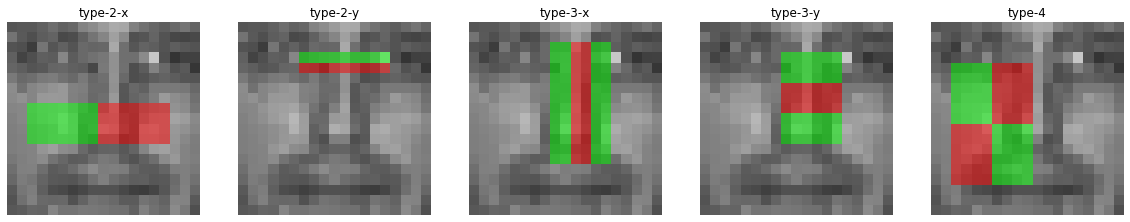

In [13]:
new_image, feature_coords, feature_type = plot_features(image_face, feature_types)
fig, axes = plt.subplots(1, 5, figsize=(20,20))

axes[0].imshow(new_image[0], cmap="gray")
axes[0].set_title(feature_types[0])
axes[0].axis('off')

axes[1].imshow(new_image[1], cmap="gray")
axes[1].set_title(feature_types[1])
axes[1].axis('off')

axes[2].imshow(new_image[2], cmap="gray")
axes[2].set_title(feature_types[2])
axes[2].axis('off')

axes[3].imshow(new_image[3], cmap="gray")
axes[3].set_title(feature_types[3])
axes[3].axis('off')

axes[4].imshow(new_image[4], cmap="gray")
axes[4].set_title(feature_types[4])
axes[4].axis('off')

plt.show()

## 3 Face detection using an Adaboost

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [14]:
import os
from skimage.io import imread

# List all the file names in the ./faces and ./nonfaces directories
face_filenames = os.listdir('./faces')
nonface_filenames = os.listdir('./nonfaces')

# Initialize an empty list to store the feature arrays
feature_arrays = []

# Loop through the face filenames and extract the Haar-like features
for filename in face_filenames:
    # Load the image
    image = imread('./faces/' + filename)
    
    # Extract the Haar-like features
    features = extract_feature_image(image, feature_types)
    
    # Append the feature array to the list
    feature_arrays.append(features)
    
# Loop through the nonface filenames and extract the Haar-like features
for filename in nonface_filenames:
    # Load the image
    image = imread('./nonfaces/' + filename)
    
    # Extract the Haar-like features
    features = extract_feature_image(image, feature_types)
    
    # Append the feature array to the list
    feature_arrays.append(features)
    
# Concatenate all the feature arrays into a single array
X = np.concatenate(feature_arrays)

# Initialize the class labels vector with all zeros
y = np.zeros(len(face_filenames) + len(nonface_filenames))

# Set the labels of the face images to 1
y[:len(face_filenames)] = 1

print(y)
num_zeros = (y == 0).sum()
num_ones = (y == 1).sum()

print(f'Number of zeros (nonfaces): {num_zeros}')
print(f'Number of ones (faces): {num_ones}')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Number of zeros (nonfaces): 29
Number of ones (faces): 39


**3.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [15]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets, shuffling the samples first
X_train, X_test, y_train, y_test = train_test_split(feature_arrays, y, test_size=0.3)

**3.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

**is a popular ensemble learning algorithm that combines several weak learners to form a strong learner. It is often used for classification tasks, but can also be used for regression and other types of supervised learning.**

**steps involved in the AdaBoost algorithm:
Initialize the weights of the samples to be equal.
Train a weak learner on the data, using the weights as a guide to focus more on the samples that were misclassified by the previous weak learner.
Calculate the error of the weak learner.
Increase the weights of the misclassified samples and decrease the weights of the correctly classified samples.
Repeat steps 2-4 with a new weak learner until the desired number of weak learners has been trained.
Combine the weak learners using weighted majority voting to create the final strong learner.**

In [16]:
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

# Define the number of weak learners and the learning rate for the AdaBoost classifier
n_estimators = 50
learning_rate = 1.0

# Create an instance of the AdaBoostClassifier class
adaboost = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate)

# Fit the AdaBoost classifier to the training data
adaboost.fit(X_train, np.ravel(y_train))


AdaBoostClassifier()

**3.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

**The predict method allows you to predict the labels of new samples using the trained classifier. To use the predict method, pass in the test data (X_test) as an argument and store the predicted labels in a variable**

In [17]:
# Predict the labels of the test data using the AdaBoost classifier
y_pred = adaboost.predict(X_test)

# Calculate the accuracy of the AdaBoost classifier
accuracy = adaboost.score(X_test, y_test)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.905


Change the parameter ``n_estimators`` and see what happens. Does it improve?

**The n_estimators parameter in the AdaBoostClassifier function determines the number of weak learners that are trained during the AdaBoost process. Increasing the value of n_estimators will result in more weak learners being trained, which can potentially improve the performance of the classifier. However, increasing the number of weak learners can also increase the training time and complexity of the model.**

In [18]:
from sklearn.ensemble import AdaBoostClassifier

# Define the learning rate for the AdaBoost classifier
learning_rate = 1.0

# Train an AdaBoost classifier with 10 weak learners
adaboost_10 = AdaBoostClassifier(n_estimators=10, learning_rate=learning_rate)
adaboost_10.fit(X_train, np.ravel(y_train))

# Predict the labels of the test data using the AdaBoost classifier
y_pred_10 = adaboost_10.predict(X_test)

# Calculate the accuracy of the AdaBoost classifier
accuracy_10 = adaboost_10.score(X_test, y_test)

print(f"Accuracy (n_estimators=10): {accuracy_10:.3f}")

# Train an AdaBoost classifier with 50 weak learners
adaboost_50 = AdaBoostClassifier(n_estimators=50, learning_rate=learning_rate)
adaboost_50.fit(X_train, np.ravel(y_train))

# Predict the labels of the test data using the AdaBoost classifier
y_pred_50 = adaboost_50.predict(X_test)

# Calculate the accuracy of the AdaBoost classifier
accuracy_50 = adaboost_50.score(X_test, y_test)

print(f"Accuracy (n_estimators=50): {accuracy_50:.3f}")


Accuracy (n_estimators=10): 0.857
Accuracy (n_estimators=50): 0.905


**3.5** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

In [19]:
def plot_features_aux(image, feature_types):
    new_image = []
    
    # Compute the integral image
    integral = to_integral_image(image)
    
    # Compute the coordinates of the Haar-like features
    feature_coords, feature_types = haar_like_feature_coord(image.shape[1], image.shape[0], feature_type=feature_types)
    
    # Loop through the feature coordinates and draw the features on the image
    for feature_coord in feature_coords:
        new_image.append(draw_haar_like_feature(image, 0, 0, image.shape[1], image.shape[0], [feature_coord], max_n_features = None))
    
    return new_image, feature_coords, feature_types

In [20]:
#your solution
from skimage.feature import draw_haar_like_feature

def plot_important_features(adaboost, image, feature_type, n_features=10):
    # Extract the Haar-like features from the image
    features = extract_feature_image(image, feature_type)
    
    # Get the feature importances from the AdaBoost classifier
    importances = adaboost.feature_importances_
    
    # Sort the importances in descending order
    sorted_importances = np.sort(importances)[::-1]
    
    # Get the indices of the n_features most important features
    top_indices = np.argsort(importances)[-n_features:]
    

    new_image, ft_coord, ft_type = plot_features_aux(image, feature_type)
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    pos = 0
    for i in top_indices:
        axes[pos].axis('off')
        axes[pos].set_title(i)
        axes[pos].imshow(new_image[i], cmap="gray")
        pos += 1
        
    plt.show()

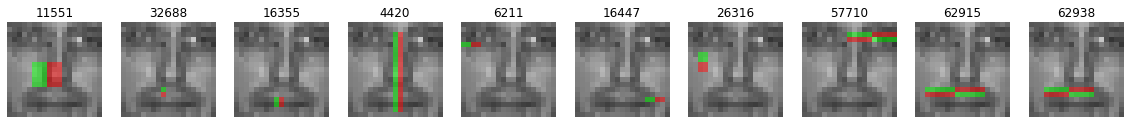

In [21]:
plot_important_features(adaboost, image_face, feature_types, n_features=10)

**3.6 (Optional)** Implement the Adaboost training the model using a different number of features. For instace,  just using 1 type of feature, 2 types, and 3 types. Plot the results comparing the precision. Draw conclusions about the results

In [22]:
#your solution


==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 4. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**4.1** Load the dataset, obtaining only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [23]:
#your solution
from sklearn.datasets import fetch_lfw_people

# Load the LFW dataset and set the minimum number of images per person to 100
lfw_people = fetch_lfw_people(min_faces_per_person=100)

# Get the number of images in the dataset
n_images = lfw_people.images.shape[0]

# Get the image shapes
image_shape = lfw_people.images.shape[1:]

# Get the labels of the images
labels = lfw_people.target

# Print the number of images, image shapes, and labels
print(f"Number of images: ", n_images)
print(f"Image shape: ", image_shape)
print(f"Labels: ", labels)


Number of images:  1140
Image shape:  (62, 47)
Labels:  [2 3 1 ... 4 2 4]


**4.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

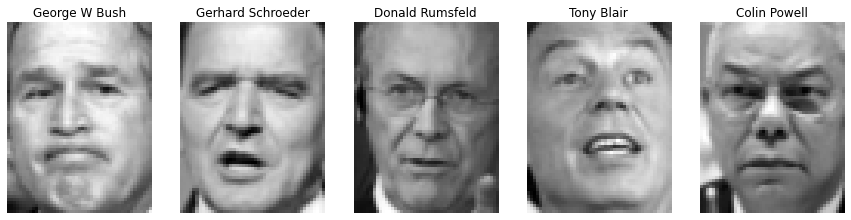

In [24]:
#your solution
import matplotlib.pyplot as plt

# Loop through each image in the LFW dataset
fig, axes = plt.subplots(1, 5, figsize=(15,15))
names = []
pos = []
img = 0
i = 0
while len(names) < 5:
    image = lfw_people.images[img]
    label = lfw_people.target_names[lfw_people.target[img]]
    
    
    if label not in names:
    
        # Plot the image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(label)
        axes[i].axis('off')
        i += 1
        
        names.append(label)
    img += 1
        
    
    
# Show the plot
plt.show()

**4.3** Divide the dataset into train and test set (0.7/0.3). 

Hint: use the train_test_split function.

In [25]:
#your solution
from sklearn.model_selection import train_test_split

# Split the LFW dataset into a train and test set with a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, test_size=0.3)


## 5. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**5.1** Create a PCA object, using the training set and a 150 components

In [26]:
#your solution
from sklearn.decomposition import PCA

# Create a PCA object with 150 components
pca = PCA(n_components=150)

# Fit the PCA object to the training set
pca.fit(X_train)


PCA(n_components=150)

Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

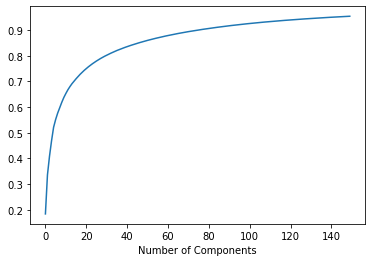

In [27]:
#your solution
import matplotlib.pyplot as plt

# Get the explained variance ratio of the components
explained_variance = pca.explained_variance_ratio_

# Cumulative sum of the explained variance ratio
cumulative_sum = np.cumsum(explained_variance)

# Plot the cumulative sum of the explained variance ratio
plt.plot(cumulative_sum)

# Set the x-axis label to "Number of Components"
plt.xlabel("Number of Components")

# Show the plot
plt.show()


**5.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

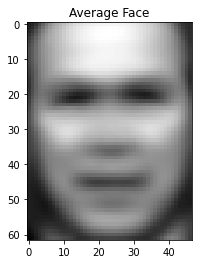

In [28]:
#your solution
import matplotlib.pyplot as plt

n_samples, high, weight = lfw_people.images.shape

# Get the average face from the PCA object
average_face = pca.mean_

# Reshape the average face into a 2D array of the same shape as the original images
average_face_image = average_face.reshape(image_shape)

# Plot the average face
plt.imshow(average_face_image, cmap="gray")

# Set the title of the plot to "Average Face"
plt.title("Average Face")

# Show the plot
plt.show()


**5.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="notebook_images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

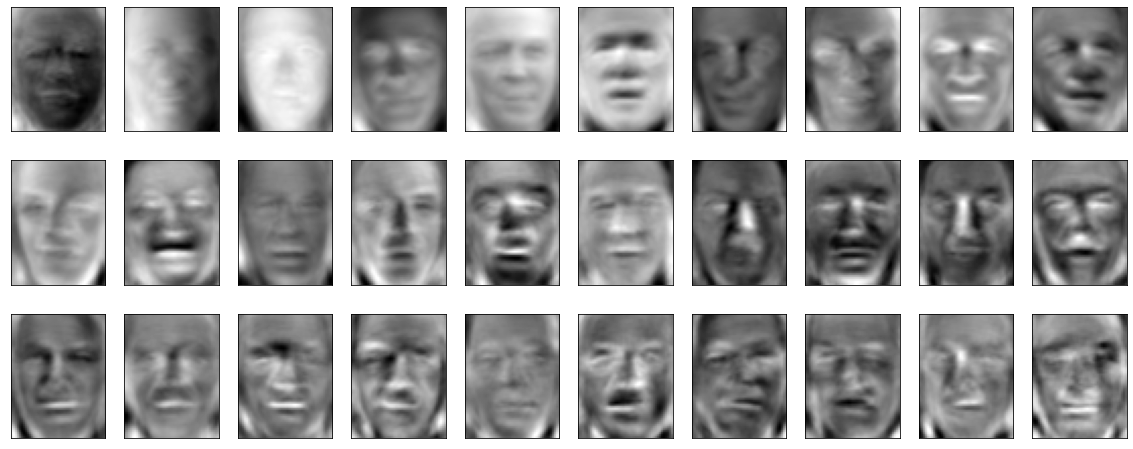

In [29]:
#your solution
import matplotlib.pyplot as plt

# Get the eigenfaces from the PCA object
eigenfaces = pca.components_

# Get the first 30 eigenfaces
eigenfaces = eigenfaces[:30]

# Create a figure with a grid of subplots
fig, ax = plt.subplots(3, 10, figsize=(20, 8))

# Loop through the eigenfaces
for i, eigenface in enumerate(eigenfaces):
    # Reshape the eigenface into a 2D array of the same shape as the original images
    eigenface_image = eigenface.reshape(image_shape)
    
    # Plot the eigenface as an image in the subplot
    ax[i // 10, i % 10].imshow(eigenface_image, cmap="gray")
    
    # Remove the x and y ticks from the plot
    ax[i // 10, i % 10].set_xticks([])
    ax[i // 10, i % 10].set_yticks([])

# Show the plot
plt.show()

#The i // 10 and i % 10 expressions are used to index the rows and columns of the ax array, respectively.The // operator 
#performs integer division (i.e. division that returns an integer result), so i // 10 will return the integer division of i by
#10. The % operator returns the remainder of the division, so i % 10 will return the remainder of i divided by 10. 

**5.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [30]:
#your solution
# Project the training set onto the PCA basis
X_train_pca = pca.transform(X_train)

# Project the test set onto the PCA basis
X_test_pca = pca.transform(X_test)


Do you need to apply the same to the variable y?

**No, the PCA transformation is applied only to the feature matrix (X), not to the target vector (y). The target vector is used to specify the class labels of the samples and is not transformed by PCA. After applying the PCA transformation to the feature matrix, you can use the transformed feature matrix and the original target vector to train a classifier or evaluate its performance.**

**5.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


In [31]:
# Select an image from the test set
selected_image = X_test[0]

# Print the shape of the selected image
print(selected_image.shape)  # Should be (2914,)

# Reshape the selected image into a 2D array with shape (1, n_features)
selected_image_2d = selected_image.reshape(1, -1)

# Project the selected image onto the PCA basis
projected_image = pca.transform(selected_image_2d)


# Print the shape of the projected image
print(projected_image.shape)  # Should be (1, 150)


# Obtain the first 10 most important corresponding eigenfaces
eigenfaces = projected_image[:, :10]

# Add the average face to the first 10 most important corresponding eigenfaces
reconstructed_image = pca.mean_ + np.dot(eigenfaces, pca.components_[:10, :])

# Reshape the reconstructed image to the original shape of the selected image
reconstructed_image = reconstructed_image.reshape(selected_image.shape)



(2914,)
(1, 150)


## 6. Train a classifier

**6.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [32]:
#your solution
from sklearn.ensemble import AdaBoostClassifier

# Create an Adaboost classifier
adaboost = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)

# Fit the classifier to the training data
adaboost.fit(X_train_pca, y_train)


# Evaluate the classifier using the test data
test_score = adaboost.score(X_test_pca, y_test)

# Print the mean accuracy of the classifier on the test data
print(f'Test score: {test_score:.3f}')


Test score: 0.637


**6.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [33]:
from sklearn.metrics import classification_report 

y_pred = adaboost.predict(X_test_pca)

report = classification_report(
    y_test,
    y_pred,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division='warn'
)

print(report)

              precision    recall  f1-score   support

           0       0.74      0.55      0.63        76
           1       0.79      0.31      0.45        48
           2       0.62      0.88      0.72       146
           3       0.87      0.46      0.60        28
           4       0.47      0.45      0.46        44

    accuracy                           0.64       342
   macro avg       0.69      0.53      0.57       342
weighted avg       0.67      0.64      0.62       342



Please, explaing what is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg?


**Accuracy is a measure of how well a classifier is able to predict the correct class. It is calculated as the number of correct predictions divided by the total number of predictions.**

**Precision is a measure of the proportion of true positive predictions in relation to all positive predictions made by the classifier. It is calculated as the number of true positive predictions divided by the total number of positive predictions made by the classifier.**

**Recall is a measure of the proportion of true positive predictions in relation to all actual positive examples in the dataset. It is calculated as the number of true positive predictions divided by the total number of actual positive examples in the dataset.**

**F1-score is a measure that combines precision and recall. It is calculated as the harmonic mean of precision and recall, with a higher value indicating a better balance between the two.**

**Support is the number of samples of the true response that lie in that class.**

**Macro avg is the unweighted average of the precision, recall, and f1-score, with equal weight being given to each metric.**

**Weighted avg is the weighted average of the precision, recall, and f1-score, with the weight being proportional to the frequency of the class in the dataset.**

**6.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [34]:
#your solution
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

y_pred_n = adaboost.predict(X_test)
score = adaboost.score(X_test, y_test)

print("Accuracy:", score)


report = classification_report(
    y_test,
    y_pred,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division=0
)
print(report)


Accuracy: 0.5847953216374269
              precision    recall  f1-score   support

           0       0.74      0.55      0.63        76
           1       0.79      0.31      0.45        48
           2       0.62      0.88      0.72       146
           3       0.87      0.46      0.60        28
           4       0.47      0.45      0.46        44

    accuracy                           0.64       342
   macro avg       0.69      0.53      0.57       342
weighted avg       0.67      0.64      0.62       342



**Questions**

- Does computing time change using PCA? How?

**PCA is generally faster than training a model without dimensionality reduction because it reduces the number of features that the model needs to consider. This is because PCA projects the data onto a lower-dimensional space, so the model only needs to consider a smaller number of features when making predictions. This can lead to faster training times and potentially better performance, depending on the size of the dataset and the complexity of the model.**

- Which of both (with and without PCA) does give better results?

**PCA can reduce the dimensionality of the data and potentially improve the performance of the classifier**

- How does the result change if we change the number of components in PCA?

**If you increase the number of components in PCA, the amount of information retained in the transformed data will also increase. This can potentially lead to better performance for certain machine learning models, but it also increases the computational cost of the transformation. On the other hand, if you decrease the number of components, the transformed data will retain less information, which may lead to poorer performance for certain models, but it will also decrease the computational cost. It's important to keep in mind that the optimal number of components will depend on the specific task and dataset you are working with.**

- How does the result change if we change the number of estimators in the Adaboost?

**Increasing the number of estimators in the Adaboost classifier improves the performance of the model. However, this comes at the cost of increased computation time.**

**6.4 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

## 7. Recognize a new face example using the learned model

**7.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

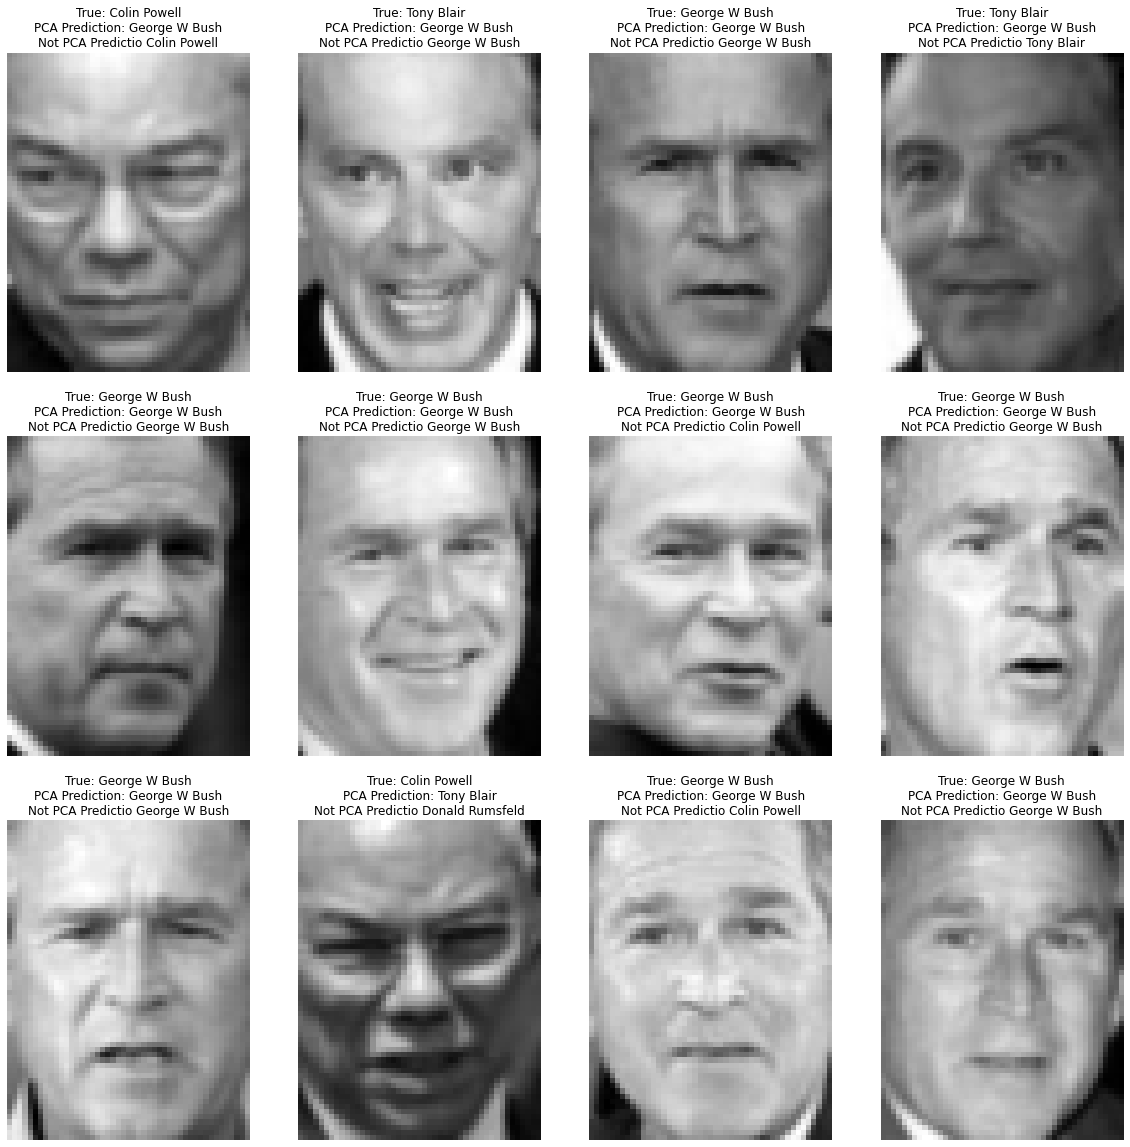

In [35]:
#your solution
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
names = lfw_people.target_names

ax[0][0].imshow(X_test[0].reshape((high,weight)), cmap="gray")
ax[0][0].set_title(f"True: {names[y_test[0]]}\nPCA Prediction: {names[y_pred[0]]}\nNot PCA Predictio {names[y_pred_n[0]]}")
ax[0][0].axis("off")

ax[0][1].imshow(X_test[1].reshape((high,weight)), cmap="gray")
ax[0][1].set_title(f"True: {names[y_test[1]]}\nPCA Prediction: {names[y_pred[1]]}\nNot PCA Predictio {names[y_pred_n[1]]}")
ax[0][1].axis("off")

ax[0][2].imshow(X_test[2].reshape((high,weight)), cmap="gray")
ax[0][2].set_title(f"True: {names[y_test[2]]}\nPCA Prediction: {names[y_pred[2]]}\nNot PCA Predictio {names[y_pred_n[2]]}")
ax[0][2].axis("off")

ax[0][3].imshow(X_test[3].reshape((high,weight)), cmap="gray")
ax[0][3].set_title(f"True: {names[y_test[3]]}\nPCA Prediction: {names[y_pred[3]]}\nNot PCA Predictio {names[y_pred_n[3]]}")
ax[0][3].axis("off")

ax[1][0].imshow(X_test[4].reshape((high,weight)), cmap="gray")
ax[1][0].set_title(f"True: {names[y_test[4]]}\nPCA Prediction: {names[y_pred[4]]}\nNot PCA Predictio {names[y_pred_n[4]]}")
ax[1][0].axis("off")

ax[1][1].imshow(X_test[5].reshape((high,weight)), cmap="gray")
ax[1][1].set_title(f"True: {names[y_test[5]]}\nPCA Prediction: {names[y_pred[5]]}\nNot PCA Predictio {names[y_pred_n[5]]}")
ax[1][1].axis("off")

ax[1][2].imshow(X_test[6].reshape((high,weight)), cmap="gray")
ax[1][2].set_title(f"True: {names[y_test[6]]}\nPCA Prediction: {names[y_pred[6]]}\nNot PCA Predictio {names[y_pred_n[6]]}")
ax[1][2].axis("off")

ax[1][3].imshow(X_test[7].reshape((high,weight)), cmap="gray")
ax[1][3].set_title(f"True: {names[y_test[7]]}\nPCA Prediction: {names[y_pred[7]]}\nNot PCA Predictio {names[y_pred_n[7]]}")
ax[1][3].axis("off")

ax[2][0].imshow(X_test[8].reshape((high,weight)), cmap="gray")
ax[2][0].set_title(f"True: {names[y_test[8]]}\nPCA Prediction: {names[y_pred[8]]}\nNot PCA Predictio {names[y_pred_n[8]]}")
ax[2][0].axis("off")

ax[2][1].imshow(X_test[9].reshape((high,weight)), cmap="gray")
ax[2][1].set_title(f"True: {names[y_test[9]]}\nPCA Prediction: {names[y_pred[9]]}\nNot PCA Predictio {names[y_pred_n[9]]}")
ax[2][1].axis("off")

ax[2][2].imshow(X_test[10].reshape((high,weight)), cmap="gray")
ax[2][2].set_title(f"True: {names[y_test[10]]}\nPCA Prediction: {names[y_pred[10]]}\nNot PCA Predictio {names[y_pred_n[10]]}")
ax[2][2].axis("off")

ax[2][3].imshow(X_test[11].reshape((high,weight)), cmap="gray")
ax[2][3].set_title(f"True: {names[y_test[11]]}\nPCA Prediction: {names[y_pred[11]]}\nNot PCA Predictio {names[y_pred_n[11]]}")
ax[2][3].axis("off")

plt.show()

Which model makes the predictions betters? Try different parameters and comment their effect on the model performance.